### Problem Statement
<br/>

💥 [Competition](https://datahack.analyticsvidhya.com/contest/club-mahindra-dataolympics/)  

<br/>

#### Food & Beverages Spend Prediction in Club Mahindra Resorts

Club Mahindra (Club M) makes significant revenue from Food and Beverages (F&B) sales in their resorts. The members of Club M are offered a wide variety of items in either buffet or À la carte form. Following are some benefits that the model to predict the spend by a member in their next visit to a resort will bring: 
- Predicting the F&B spend of a member in a resort would help in improving the pre-sales during resort booking through web and mobile app
- Targeted campaigns to suit the member taste and preference of F&B
- Providing members in the resort with a customized experience and offers
- Help resort kitchen to plan the inventory and food quantity to be prepared in advance

Given the information related to resort, club member, reservation etc. the task is to **predict average spend per room night on food and beverages for the each reservation in the test set**.

<br/>

#### Evaluation Metric

Submissions are evaluated on **100 * Root Mean Squared Error (RMSE)** on the variable amount_spent_per_room_night_scaled.  
$$RMSE = \sqrt{ 1/n \cdot \sum_{i=1}^{n}(y_{i} - \hat{y_{i}})^{2} }$$

<br/>

💥 <span style="color:red">Response variable</span>: **amount_spent_per_room_night_scaled**

<br/>

#### Public and Private Split
Test data is further randomly divided into Public (30%) and Private (70%) data.  
Your initial responses will be checked and scored on the Public data.  
The final rankings would be based on your private score which will be published once the competition is over.



### Import Libraries

In [45]:
import os, sys, time, gc, warnings, re 
import datetime as dt
warnings.filterwarnings("ignore")

import itertools as it
import operator as op

import numpy as np
import scipy.stats as stats
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML, Markdown

sys.path.append(os.environ["PY_UTILITIES_LIBRARY"]) # PY_UTILITIES_LIBRARY points to our custom library

%matplotlib inline

In [46]:
%reload_ext watermark
%watermark -iv -d -t -v -w -m

matplotlib3.0.3
scipy     1.2.1
json      2.0.9
holidays  0.9.10
numpy     1.16.2
seaborn   0.9.0
pandas    0.24.2
re        2.2.1
2019-05-05 03:09:23 

CPython 3.6.8
IPython 7.5.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores  : 12
interpreter: 64bit
watermark 1.8.0


### Configure Notebook

In [47]:
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_colwidth", -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('io.hdf.default_format','fixed') # store binary data in HDF5 'table' format or 'fixed' format
sns.set(context='paper', style="darkgrid", rc={'axes.labelcolor': 'black', 'xtick.color': 'black', 'ytick.color': 'black', 'figure.facecolor':'white'}, 
        font_scale=1.3)
HTML("<style>table {font-size:14px} </style>")

def printmd(string, color=None):
    """colors in hex"""
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [48]:
%reload_ext autoreload
%autoreload 2

rs_seed = np.random.RandomState(seed=43)

### Define Notebook Parameters

In [49]:
# see papermill package
train_file = "./train_5CLrC8b.zip"
test_file = "./test_Jwt0MQH.zip"

target = "amount_spent_per_room_night_scaled"
object_id = "reservation_id"

In [83]:
# imports
from ml_toolbelt.ioutils.file_utils import load_data
from ml_toolbelt.utils.stat_utils import describe_numeric, describe_categorical
from ml_toolbelt.utils.stat_utils import (check_level_diff_nominal, check_train_test_diff_quantitative, check_train_test_missing, 
                                         compute_p_norm_distance_in_categorical_series, show_feature_diff_train_test)
from ml_toolbelt.utils.stat_utils import ecdf
from statsmodels.distributions.empirical_distribution import ECDF
from ml_toolbelt.mlutils.ml_utils import blended_ranked_predictions

import holidays

### Load Data

In [51]:
train_df = load_data(train_file, "train.csv", None, None, None, save_load_to_hdf5=False, chunk_size=50000)
train_df.info()

['Data_Dictionary.xlsx', 'train.csv']
[INFO] Loaded batch 1...
[INFO] Loaded batch 2...
[INFO] Loaded batch 3...
[INFO] Loaded batch 4...
[INFO] Loaded batch 5...
[INFO] Loaded batch 6...
[INFO] Loaded batch 7...
Memory usage of dataframe is 62.52 MB
Memory usage after optimization is: 29.63 MB
Decreased by 52.6%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341424 entries, 0 to 341423
Data columns (total 24 columns):
reservation_id                        341424 non-null object
booking_date                          341424 non-null object
checkin_date                          341424 non-null object
checkout_date                         341424 non-null object
channel_code                          341424 non-null int8
main_product_code                     341424 non-null int8
numberofadults                        341424 non-null int8
numberofchildren                      341424 non-null int8
persontravellingid                    341424 non-null int16
resort_region_code                

In [52]:
test_df = load_data(test_file, "test.csv", None, None, None, save_load_to_hdf5=False, chunk_size=50000)
test_df.info()

['test.csv']
[INFO] Loaded batch 1...
[INFO] Loaded batch 2...
[INFO] Loaded batch 3...
Memory usage of dataframe is 25.75 MB
Memory usage after optimization is: 12.46 MB
Decreased by 51.6%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146765 entries, 0 to 146764
Data columns (total 23 columns):
reservation_id              146765 non-null object
booking_date                146765 non-null object
checkin_date                146765 non-null object
checkout_date               146765 non-null object
channel_code                146765 non-null int8
main_product_code           146765 non-null int8
numberofadults              146765 non-null int8
numberofchildren            146765 non-null int8
persontravellingid          146765 non-null int16
resort_region_code          146765 non-null int8
resort_type_code            146765 non-null int8
room_type_booked_code       146765 non-null int8
roomnights                  146765 non-null int8
season_holidayed_code       146730 non-null float16
s

### EDA + Pre-processing + Feature Engineering

In [53]:
describe_categorical(train_df, np.setdiff1d(train_df.columns, [target]))

,booking_date,booking_type_code,channel_code,checkin_date,checkout_date,cluster_code,main_product_code,member_age_buckets,memberid,numberofadults,numberofchildren,persontravellingid,reservation_id,reservationstatusid_code,resort_id,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax
count_non_missing_,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341310,336660,341424,341424
count_missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,114,4764,0,0
top_,02/09/16,1,1,08/10/16,21/10/18,F,2,D,81c5295dd0cd56d704882cd28c7c815658ba5796165b7d14dd39a6f4d5ee2842,2,0,45,9375e35932593813876f0ed99f5c96d395f0ceb4cbb7b3c469e84fb41e469f6d,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f90da3a666eec13ab35,1,1,3,3,2.000,8.000,1,2
freq_,1353,299016,161225,460,491,120623,177615,67618,50,149414,264250,267307,1,312481,35331,143790,154324,137439,94256,126771,134919,59830,106046
%freq_,0.40%,87.58%,47.22%,0.13%,0.14%,35.33%,52.02%,19.80%,0.01%,43.76%,77.40%,78.29%,0.00%,91.52%,10.35%,42.11%,45.20%,40.25%,27.61%,37.13%,39.52%,17.52%,31.06%
dtype_,object,int8,int8,object,object,object,int8,object,object,int8,int8,int16,object,object,object,int8,int8,int8,int8,float16,float16,int8,int8
nunique_,1621,2,3,1532,1531,6,5,10,101327,28,12,6,341424,4,32,3,7,6,44,4,37,11,18
%missing_,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.033%,1.395%,0.000%,0.000%
entropy,10.437,0.541,1.456,10.530,10.532,2.406,1.682,2.932,16.317,2.173,1.073,1.094,18.381,0.504,4.626,1.515,2.183,1.684,2.782,1.817,3.198,3.172,2.135


In [54]:
# date format: DD/MM/YY
# members booked more than once: memberid, do they appear in test set?
# reservationstatusid_code: does A means Approved?
# season_holidayed_code that member subscribed for: Purple, Red,  White, Blue (preference)
# roomnights = # of rooms * # of nights
# length of stay / # of nights = checkout_date - checkin_date
# resort_id: do they appear in test set?
# resort_type_code: Beach, City, Desert, Hill Station, Himalayan, Jungle, Waterfront
# checkin_date: create date features (holiday, workday, season(winter, spring, summer, autumn), quarter of year, beginning of month, festival, 
#               national holiday, beginning of year, end of year, special days ...) 
#               Season: https://en.wikipedia.org/wiki/Season (See: Six-season calendar reckoning)
# main_product_code: Club Mahindra Holidays, Club Mahindra Fundays, Club Mahindra Bliss, Club Mahindra Experience
# checkin_date - booking_date: early booking vs. late booking?

date_features = ["booking_date", "checkin_date", "checkout_date"]
binary_features = ["booking_type_code"]
nominal_fatures = ["channel_code", "cluster_code", "memberid", "persontravellingid", "reservationstatusid_code", 
                   "resort_id", "resort_region_code", "resort_type_code", "room_type_booked_code", "state_code_residence",
                   "state_code_resort"]
ordinal_features = ["main_product_code", "member_age_buckets", "season_holidayed_code"]
numeric_discrete_features = ["numberofadults", "numberofchildren", "roomnights", "total_pax"]

def get_six_seasons(date_):
    leap_add = 1 if date_.is_leap_year else 0
    if date_.dayofyear >= 15 and date_.dayofyear < (74 + leap_add):
        return "late winter"
    elif date_.dayofyear >= (74 + leap_add) and date_.dayofyear < (135 + leap_add):
        return "spring"
    elif date_.dayofyear >= (135 + leap_add) and date_.dayofyear < (196 + leap_add):
        return "summer"
    elif date_.dayofyear >= (196 + leap_add) and date_.dayofyear < (258 + leap_add):
        return "monsoon"
    elif date_.dayofyear >= (258 + leap_add) and date_.dayofyear < (319 + leap_add):
        return "autumn"
    else:
        return "early winter"
    
india_holidays = holidays.IND(years=range(2010,2030))

In [55]:
# dates
def preprocess_dates(df):
    df[date_features] = df[date_features].apply(lambda x: pd.to_datetime(x, format="%d/%m/%y", errors="raise"), axis=0)
    
def generate_date_features(df):
    df["booking_delay"] = (df["checkin_date"] - df["booking_date"]).dt.days       # convert to days
    df["length_of_stay"] = (df["checkout_date"] - df["checkin_date"]).dt.days     # convert to days
    df["rooms_booked"] = df["roomnights"] / df["length_of_stay"]                  # occupancy rate
    df["checkin_month"] = df["checkin_date"].dt.month
    #df["checkin_hour"] = df["checkin_date"].dt.hour
    df["checkin_dayofweek"] = df["checkin_date"].dt.dayofweek
    df["checkin_is_leap_year"] = df["checkin_date"].dt.is_leap_year
    df["checkin_is_year_start"] = df["checkin_date"].dt.is_year_start
    df["checkin_is_year_end"] = df["checkin_date"].dt.is_year_end
    df["checkin_is_quarter_start"] = df["checkin_date"].dt.is_quarter_start
    df["checkin_is_quarter_end"] = df["checkin_date"].dt.is_quarter_end
    df["checkin_is_month_start"] = df["checkin_date"].dt.is_month_start
    df["checkin_is_month_end"] = df["checkin_date"].dt.is_month_end
    df["checkin_weekofyear"] = df["checkin_date"].dt.weekofyear
    df["checkin_dayofyear"] = df["checkin_date"].dt.dayofyear
    df["checkin_quarter"] = df["checkin_date"].dt.quarter
    df["season6_checkin"] = df["checkin_date"].map(lambda x: get_six_seasons(x))    # season of checkin date
    df["season6_booking"] = df["booking_date"].map(lambda x: get_six_seasons(x))    # season of booking date
    df["checkin_weekend"] = df["checkin_dayofweek"].isin([5,6])                     # is it weekend?
    df["checkin_holiday"] = df["checkin_date"].isin(india_holidays)                 # was it a national holiday in India?
    
def convert_to_binary(df):
    """Convert boolean features to 1's and 0s
    """
    feats = df.select_dtypes(include=["bool"]).columns
    df[feats] = df[feats].apply(lambda x: x.astype(np.int8), axis=0)

In [56]:
# transform dates
preprocess_dates(train_df)
preprocess_dates(test_df)

In [57]:
# Is the train and test set split by booking_date? No.
print( train_df.select_dtypes(include=["datetime"]).apply(lambda x: print("{}: Min: {}, Max: {}".format(x.name, x.min(), x.max())) ) )
print()
print( test_df.select_dtypes(include=["datetime"]).apply(lambda x: print("{}: Min:{}, Max:{}".format(x.name, x.min(), x.max())) ) )
# booking_date later than checkin_date???
train_df.query("checkin_date < booking_date")

booking_date: Min: 2014-09-03 00:00:00, Max: 2019-03-01 00:00:00
checkin_date: Min: 2012-03-08 00:00:00, Max: 2019-03-01 00:00:00
checkout_date: Min: 2012-03-11 00:00:00, Max: 2019-03-03 00:00:00
booking_date     None
checkin_date     None
checkout_date    None
dtype: object

booking_date: Min:2014-09-03 00:00:00, Max:2019-03-01 00:00:00
checkin_date: Min:2012-04-20 00:00:00, Max:2019-03-01 00:00:00
checkout_date: Min:2012-04-24 00:00:00, Max:2019-03-03 00:00:00
booking_date     None
checkin_date     None
checkout_date    None
dtype: object


,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled
15,821a5e5313029b1bbec6ec738a1b34d6d14c82fca97c47851dcdafd0c0e4a43a,2018-04-05,2012-03-08,2012-03-11,3,1,2,0,45,1,1,2,1,3.000,8.000,6,3,H,1,7b68caeb153ac83aeab0b9a679709c558d57a6c9d2bdf696ed73ba34ac10af11,F,C,49d180ecf56132819571bf39d9b7b342522a2ac6d23c1418d3338251bfe469c8,3.219
34,a80d2fbea1195021307a13a44642855c60f46145dcf29c835142d31d6b5f0848,2018-03-31,2012-03-12,2012-03-18,3,2,3,0,45,1,1,3,2,2.000,5.000,1,3,D,2,d4eee99d5c3238cdda52479fb34125e15208d394af34e760b73ce6b8116c1f9a,E,C,48449a14a4ff7d79bb7a1b6f3d488eba397c36ef25634c111b49baf362511afc,7.031
60,51fe7242f55c79aacb499f957c746445ccb51de3c8d206d8fff7cb98881c68cb,2018-04-05,2012-03-24,2012-03-25,3,2,2,0,45,3,3,3,1,2.000,6.000,3,4,I,1,a24896d1582d8b6c0de997d8b7435962e33580ba80839d6444ed3a103e6d9122,A,C,f5ca38f748a1d6eaf726b8a42fb575c3c71f1864a8143301782de13da2d9202b,9.141
79,548605b68da37dd5c8555a37650910ce9f110e793b461998b3ead56f29ad2f01,2018-04-05,2012-03-21,2012-03-25,1,3,3,1,45,3,3,2,6,2.000,4.000,5,3,E,1,3bb1aa01c771c2217fe08bae162569a3177da7d09ae6be2fa4c86b59506aec8b,F,A,7902699be42c8a8e46fbbb4501726517e86b22c56a189f7625a6da49081b2451,7.254
81,3ac8796577c899cd0177b6f9638515e4feab55d8a72b8b81f388bcbf00658b22,2018-04-05,2012-03-23,2012-03-26,1,3,4,0,45,1,1,3,4,2.000,2.000,1,3,E,1,fa856d4dde8f88ed2855a74e2468cedd802ee253434a6c601ffbc65b75855bc3,E,C,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b,7.230
113,4d73a3304416c4bff78b47c6b307a07568d7286d946e3ea2fe0dca2a30e33afb,2018-04-06,2012-04-09,2012-04-11,1,2,3,1,45,1,2,2,4,3.000,1.000,11,6,D,1,c2eaeada5db1e75552e54382c408fe1c600679060b052c95d8655a777121f6a6,F,C,e29c9c180c6279b0b02abd6a1801c7c04082cf486ec027aa13515e4f3884bb6b,6.516
116,8e7c40db97f7088ea2249bb9da85b1cfce31c8b537dcfa72b328b7836a9dc80c,2018-04-06,2012-04-14,2012-04-15,1,3,4,0,45,1,2,2,2,3.000,1.000,11,4,G,1,48a9cdd22b472fe4aa225acd45acdbe246de12fade4a59261426fe2f692b8034,F,C,e29c9c180c6279b0b02abd6a1801c7c04082cf486ec027aa13515e4f3884bb6b,8.820
129,085264337c2af42038a81b4ec4d9e278d9699e5662d404b221b931caf695743f,2018-04-06,2012-04-19,2012-04-21,3,1,2,0,45,3,3,4,1,2.000,5.000,5,3,B,1,914d3756e6da218a071578d46a3a3c4fce3b773a1736cb79114931afa35c79ef,F,C,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac8f9e9a2596173f80c9,8.250
130,7294817a3becfb22650a6e4cf0dd7d2a3a1a3969e1e01dcff41d9da69333b5c3,2018-04-06,2012-04-19,2012-04-21,3,1,2,0,45,3,3,4,1,2.000,5.000,5,3,B,1,914d3756e6da218a071578d46a3a3c4fce3b773a1736cb79114931afa35c79ef,F,C,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac8f9e9a2596173f80c9,3.193
147,e36df886dd8222cad63291754719419d5ff50b44e525e00b940731a923b198c0,2018-04-06,2012-04-22,2012-04-26,3,3,4,0,45,1,1,3,1,3.000,9.000,6,3,B,2,0beacf60d9f72cdfe3f4b8f1f439c605b9bc37ca3a39220e603e8ea92396affc,F,A,b17ef6d19c7a5b1ee83b907c595526dcb1eb06db8227d650d5dda0a9f4ce8cd9,7.016


In [58]:
test_df.query("checkin_date < booking_date")

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id
41,6ec2dd92d278aa97f8ab095ac0c0d18a7e9f18753c51c798a25c2d3a7f816212,2018-04-06,2012-04-20,2012-04-24,3,3,2,0,4752,2,2,2,2,3.000,8.000,2,4,H,1,4e13e5c5482a6eba4e7badc21204f2add76b7203efe407fd4c16f6073acaa02f,D,C,98a3ab7c340e8a033e7b37b6ef9428751581760af67bbab2b9e05d4964a8874a
57,54bf09a310761d2f874666557e3706012d85a47b14d0b8e5bd393344335b3b6f,2018-04-06,2012-04-28,2012-05-01,3,1,3,0,45,1,1,3,7,2.000,8.000,4,3,E,2,da2840cf5dd988b0641f48758a164621c36c26f7c48703a6b3474073367b6762,F,C,e7f6c011776e8db7cd330b54174fd76f7d0216b612387a5ffcfb81e6f0919683


In [59]:
# winsorize booking_dates
def winsorize_booking_dates(df):
    idxs = df.query("checkin_date < booking_date").index
    df.loc[idxs, "booking_date"] = df.loc[idxs, "checkin_date"]

winsorize_booking_dates(train_df)
winsorize_booking_dates(test_df)

print(train_df.query("checkin_date < booking_date").shape)
print(test_df.query("checkin_date < booking_date").shape)

(0, 24)
(0, 23)


In [60]:
# distribution between train and test set - missingness
check_train_test_missing(train_df, test_df, test_df.columns)

                          train  test
reservation_id           0.000  0.000
booking_date             0.000  0.000
checkin_date             0.000  0.000
checkout_date            0.000  0.000
channel_code             0.000  0.000
main_product_code        0.000  0.000
numberofadults           0.000  0.000
numberofchildren         0.000  0.000
persontravellingid       0.000  0.000
resort_region_code       0.000  0.000
resort_type_code         0.000  0.000
room_type_booked_code    0.000  0.000
roomnights               0.000  0.000
season_holidayed_code    0.033  0.024
state_code_residence     1.395  1.540
state_code_resort        0.000  0.000
total_pax                0.000  0.000
member_age_buckets       0.000  0.000
booking_type_code        0.000  0.000
memberid                 0.000  0.000
cluster_code             0.000  0.000
reservationstatusid_code 0.000  0.000
resort_id                0.000  0.000


In [61]:
# distribution between train and test set - categorical
check_level_diff_nominal(train_df, test_df, 
                         np.setdiff1d(train_df.select_dtypes(exclude=["number", "datetime"]).columns, [object_id]))
# we observe new memberids in test set

feature  no_of_differences  \
0  cluster_code              0                   
1  member_age_buckets        0                   
2  memberid                  43496               
3  reservationstatusid_code  0                   
4  resort_id                 0                   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

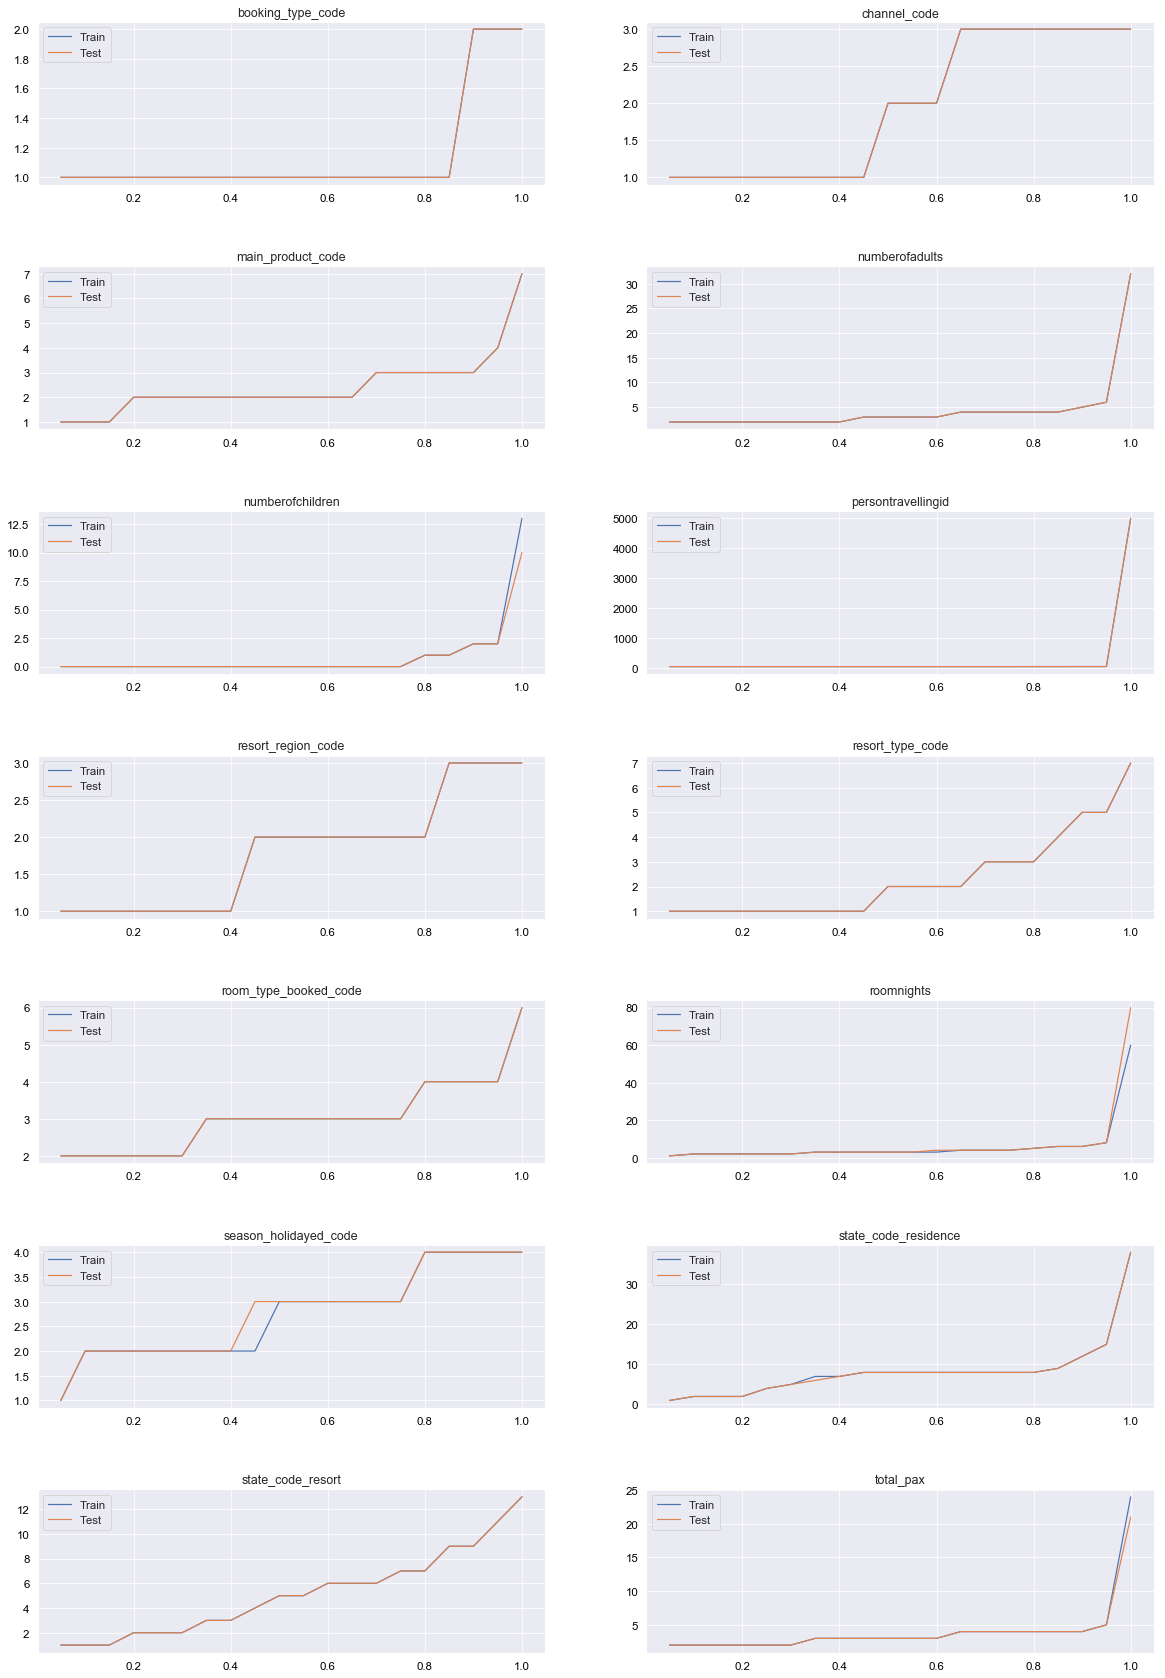

In [62]:
# distribution between train and test set - numeric
check_train_test_diff_quantitative(train_df, test_df, 
                                     np.setdiff1d(train_df.select_dtypes(exclude=["object", "datetime"]).columns, [object_id, target]), 
                                  rows=7, cols=2)

In [63]:
# look for changes in distribution of features
show_feature_diff_train_test(train_df, test_df, 
                             np.setdiff1d(train_df.select_dtypes(exclude=["datetime"]).columns, [object_id, target]))

# Note: memberid's are disjoint between training and test set
#       train and test set are (probably randomly) split by memberid's

Feature: booking_type_code, Number of unseen values in training set: 0, Fraction of these unseen values in testing set: 0.0% (0) 
Feature: channel_code, Number of unseen values in training set: 0, Fraction of these unseen values in testing set: 0.0% (0) 
Feature: cluster_code, Number of unseen values in training set: 0, Fraction of these unseen values in testing set: 0.0% (0) 
Feature: main_product_code, Number of unseen values in training set: 0, Fraction of these unseen values in testing set: 0.0% (0) 
Feature: member_age_buckets, Number of unseen values in training set: 0, Fraction of these unseen values in testing set: 0.0% (0) 
Feature: memberid, Number of unseen values in training set: 43496, Fraction of these unseen values in testing set: 100.0% (146765) 
Feature: numberofadults, Number of unseen values in training set: 1, Fraction of these unseen values in testing set: 0.006813613599972746% (10) 
Feature: numberofchildren, Number of unseen values in training set: 1, Fraction of

In [64]:
# transform train
generate_date_features(train_df)
convert_to_binary(train_df)
# test
generate_date_features(test_df)
convert_to_binary(test_df)

In [65]:
describe_categorical(train_df, np.setdiff1d(train_df.columns, [target]))

,booking_date,booking_delay,booking_type_code,channel_code,checkin_date,checkin_dayofweek,checkin_dayofyear,checkin_holiday,checkin_is_leap_year,checkin_is_month_end,checkin_is_month_start,checkin_is_quarter_end,checkin_is_quarter_start,checkin_is_year_end,checkin_is_year_start,checkin_month,checkin_quarter,checkin_weekend,checkin_weekofyear,checkout_date,cluster_code,length_of_stay,main_product_code,member_age_buckets,memberid,numberofadults,numberofchildren,persontravellingid,reservation_id,reservationstatusid_code,resort_id,resort_region_code,resort_type_code,room_type_booked_code,roomnights,rooms_booked,season6_booking,season6_checkin,season_holidayed_code,state_code_residence,state_code_resort,total_pax
count_non_missing_,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341310,336660,341424,341424
count_missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,114,4764,0,0
top_,2016-09-02 00:00:00,15,1,1,2016-10-08 00:00:00,4,5,0,0,0,0,0,0,0,0,1,1,0,4,2018-10-21 00:00:00,F,2,2,D,81c5295dd0cd56d704882cd28c7c815658ba5796165b7d14dd39a6f4d5ee2842,2,0,45,9375e35932593813876f0ed99f5c96d395f0ceb4cbb7b3c469e84fb41e469f6d,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f90da3a666eec13ab35,1,1,3,3,1.000,early winter,spring,2.000,8.000,1,2
freq_,1353,10109,299016,161225,460,56621,2045,332834,259072,330566,329404,337781,337291,340667,340214,34110,93050,235999,8029,491,120623,119723,177615,67618,50,149414,264250,267307,1,312481,35331,143790,154324,137439,94256,199081,60671,60926,126771,134919,59830,106046
%freq_,0.40%,2.96%,87.58%,47.22%,0.13%,16.58%,0.60%,97.48%,75.88%,96.82%,96.48%,98.93%,98.79%,99.78%,99.65%,9.99%,27.25%,69.12%,2.35%,0.14%,35.33%,35.07%,52.02%,19.80%,0.01%,43.76%,77.40%,78.29%,0.00%,91.52%,10.35%,42.11%,45.20%,40.25%,27.61%,58.31%,17.77%,17.84%,37.13%,39.52%,17.52%,31.06%
dtype_,datetime64[ns],int64,int8,int8,datetime64[ns],int64,int64,int8,int8,int8,int8,int8,int8,int8,int8,int64,int64,int8,int64,datetime64[ns],object,int64,int8,object,object,int8,int8,int16,object,object,object,int8,int8,int8,int8,float64,object,object,float16,float16,int8,int8
nunique_,1632,127,2,3,1532,7,366,2,2,2,2,2,2,2,2,12,4,2,53,1531,6,16,5,10,101327,28,12,6,341424,4,32,3,7,6,44,129,6,6,4,37,11,18
%missing_,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.033%,1.395%,0.000%,0.000%
entropy,10.437,6.685,0.541,1.456,10.530,2.800,8.497,0.170,0.797,0.203,0.220,0.085,0.094,0.023,0.034,3.578,1.995,0.892,5.708,10.532,2.406,2.078,1.682,2.932,16.317,2.173,1.073,1.094,18.381,0.504,4.626,1.515,2.183,1.684,2.782,2.005,2.583,2.581,1.817,3.198,3.172,2.135


In [66]:
describe_numeric(train_df, train_df.select_dtypes(exclude=["object", "datetime"]))

,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,booking_type_code,amount_spent_per_room_night_scaled,booking_delay,length_of_stay,rooms_booked,checkin_month,checkin_dayofweek,checkin_is_leap_year,checkin_is_year_start,checkin_is_year_end,checkin_is_quarter_start,checkin_is_quarter_end,checkin_is_month_start,checkin_is_month_end,checkin_weekofyear,checkin_dayofyear,checkin_quarter,checkin_weekend,checkin_holiday
count_non_missing,341424,341424,341424,341424,341424,341424,341424,341424,341424,341310,336660,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424,341424
min,1,1,0,0,45,1,0,1,-45,1.000,1.000,1,0,1,1.601,0,1,-6.429,1,0,0,0,0,0,0,0,0,1,1,1,0,0
max,3,7,32,13,4995,3,7,6,60,4.000,38.000,13,24,2,10.820,126,26,47.000,12,6,1,1,1,1,1,1,1,53,366,4,1,1
dtype,int8,int8,int8,int8,int16,int8,int8,int8,int8,float16,float16,int8,int8,int8,float16,int64,int64,float64,int64,int64,int8,int8,int8,int8,int8,int8,int8,int64,int64,int64,int8,int8
%missing,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.03%,1.40%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
mode,1,2,2,0,45,1,1,3,3,2.000,8.000,1,2,1,8.219,15,2,1.000,1,4,0,0,0,0,0,0,0,4,5,1,0,0
mean,1.903,2.209,3.275,0.363,210.289,1.773,2.194,2.890,3.738,NaN,NaN,4.763,3.193,1.124,NaN,46.162,2.467,1.649,6.311,3.140,0.241,0.004,0.002,0.012,0.011,0.035,0.032,25.743,176.761,2.442,0.309,0.025
median,2.000,2.000,3.000,0.000,45.000,2.000,2.000,3.000,3.000,3.000,8.000,5.000,3.000,1.000,7.859,33.000,2.000,1.000,6.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,25.000,169.000,2.000,0.000,0.000
std,0.915,0.824,1.756,0.758,865.736,0.751,1.551,0.804,2.479,0.000,0.000,3.104,1.168,0.330,0.000,36.793,1.093,1.220,3.532,2.014,0.428,0.059,0.047,0.109,0.103,0.184,0.175,15.425,108.026,1.136,0.462,0.157
nunique,3,5,28,12,6,3,7,6,44,4,37,11,18,2,1945,127,16,129,12,7,2,2,2,2,2,2,2,53,366,4,2,2


In [67]:
# needs fix:
#  roomnights: -ve values
train_df.query("roomnights < 0") # drop these obs.
#  rooms_booked: -ve values
#  possible outliers: total_pax, length_of_stay, roomnights, persontravellingid, numberofchildren, numberofadults, main_product_code, 
#                     rooms_booked, state_code_residence

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled,booking_delay,length_of_stay,rooms_booked,checkin_month,checkin_dayofweek,checkin_is_leap_year,checkin_is_year_start,checkin_is_year_end,checkin_is_quarter_start,checkin_is_quarter_end,checkin_is_month_start,checkin_is_month_end,checkin_weekofyear,checkin_dayofyear,checkin_quarter,season6_checkin,season6_booking,checkin_weekend,checkin_holiday
36008,8cf7476b7111e0f969ef00d582f8a0833794239ebd32067d57451b3bdab22dc2,2014-12-30,2015-03-22,2015-03-29,1,2,4,3,45,1,1,2,-45,3.000,8.000,6,4,D,1,a3af543aae775ab3cac3f789f74d5c0a70e6c0ecacb0db5a18b0a4415e35729f,F,A,b17ef6d19c7a5b1ee83b907c595526dcb1eb06db8227d650d5dda0a9f4ce8cd9,7.777,82,7,-6.429,3,6,0,0,0,0,0,0,0,12,81,1,spring,early winter,1,0


In [68]:
# let's look at few of these outliers
#train_df.query("persontravellingid == 4995") # clean
#train_df.query("main_product_code == 7") # clean
train_df.query("length_of_stay > 17") # drop these obs.

# drop? or combine them using (memberid, checkin_date, persontravellingid, resort_id)?
# only response is differenet for these observations
#train_df.query("rooms_booked > 30")

#train_df.query("numberofchildren > 9") # large families
#train_df.query("numberofadults > 10") # large group
#train_df.query("main_product_code > 4") # clean
#train_df.query("state_code_residence > 25") # clean
#train_df.query("total_pax > 20") # drop? or combine them using (memberid, checkin_date, persontravellingid, resort_id)?

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled,booking_delay,length_of_stay,rooms_booked,checkin_month,checkin_dayofweek,checkin_is_leap_year,checkin_is_year_start,checkin_is_year_end,checkin_is_quarter_start,checkin_is_quarter_end,checkin_is_month_start,checkin_is_month_end,checkin_weekofyear,checkin_dayofyear,checkin_quarter,season6_checkin,season6_booking,checkin_weekend,checkin_holiday
12481,28a986f3c2b71dd6bce4d6b49bc39412355f7525c8e227a0a2910e225e0451ed,2015-01-31,2015-02-26,2015-03-24,1,1,3,2,45,1,1,4,4,4.000,10.000,4,1,E,1,6cf7b577e449b606e5805513e91628a3a76383237245bc46e2de70df59cd9c73,F,A,e7f6c011776e8db7cd330b54174fd76f7d0216b612387a5ffcfb81e6f0919683,7.602,26,26,0.154,2,3,0,0,0,0,0,0,0,9,57,1,late winter,late winter,0,0
317410,b0d07216ae51a01e8bca622007740a7a2488563f91ecb8c400b91f20e8ebce8c,2018-02-17,2018-05-25,2018-06-15,3,2,4,0,45,3,3,4,41,1.000,14.000,5,4,J,1,b0daa83c3c2fcb150f7655dc97cddd7592a66672a3a2b399ee5ea9116c39a8b7,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac8f9e9a2596173f80c9,6.039,97,21,1.952,5,4,0,0,0,0,0,0,0,21,145,2,summer,late winter,0,0


In [69]:
# drop rows
train_df = train_df.query("roomnights >= 0")
train_df = train_df.query("length_of_stay < 17")

In [70]:
train_df.shape

(341421, 43)

In [71]:
# combine observations/bookings by memberid, checkin_date, persontravellingid, resort_id
train_df["avg_target"] = train_df.groupby(["memberid", "resort_id", "persontravellingid", "checkin_date"])[target].transform(np.mean)
train_df.drop_duplicates(subset=["memberid", "resort_id", "persontravellingid", "checkin_date"], inplace=True)
print(train_df.shape)
train_df.head()

(334675, 44)


,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled,booking_delay,length_of_stay,rooms_booked,checkin_month,checkin_dayofweek,checkin_is_leap_year,checkin_is_year_start,checkin_is_year_end,checkin_is_quarter_start,checkin_is_quarter_end,checkin_is_month_start,checkin_is_month_end,checkin_weekofyear,checkin_dayofyear,checkin_quarter,season6_checkin,season6_booking,checkin_weekend,checkin_holiday,avg_target
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b752eebc9b50313e152,2018-04-05,2018-04-05,2018-04-06,3,1,2,0,46,3,3,3,1,2.000,7.000,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9acf56eb3b04793d9ae5,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de01f640b7e4729b49fce,7.707,0,1,1.000,4,3,0,0,0,0,0,0,0,14,95,2,spring,spring,0,0,7.707
1,03930f033646d073462b35d411616323597715ac4fc3982021ff25387177a782,2015-01-23,2015-04-11,2015-04-16,1,1,2,0,46,3,3,4,5,2.000,7.000,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9acf56eb3b04793d9ae5,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac8f9e9a2596173f80c9,6.664,78,5,1.000,4,5,0,0,0,0,0,0,0,15,101,2,spring,late winter,1,0,6.664
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf11ea2bb87c4b0100a4,2015-01-28,2015-02-01,2015-02-05,1,1,2,0,47,1,5,4,4,2.000,7.000,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9acf56eb3b04793d9ae5,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da5045d77f3b4185d8f790,7.871,4,4,1.000,2,6,0,0,0,0,0,1,0,5,32,1,late winter,late winter,1,0,7.871
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04782dcd41548b3974b5,2015-05-02,2015-06-11,2015-06-16,1,1,2,2,46,2,2,3,5,2.000,7.000,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9acf56eb3b04793d9ae5,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f90da3a666eec13ab35,5.344,40,5,1.000,6,3,0,0,0,0,0,0,0,24,162,2,summer,spring,0,0,5.344
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb294ba12c85962b0a9842,2015-09-02,2015-12-14,2015-12-19,1,1,2,0,46,2,2,4,5,2.000,7.000,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9acf56eb3b04793d9ae5,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f90da3a666eec13ab35,7.059,103,5,1.000,12,0,0,0,0,0,0,0,0,51,348,4,early winter,monsoon,0,0,7.059


In [72]:
train_df.query("rooms_booked > 30")
#train_df.query("total_pax > 20")

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled,booking_delay,length_of_stay,rooms_booked,checkin_month,checkin_dayofweek,checkin_is_leap_year,checkin_is_year_start,checkin_is_year_end,checkin_is_quarter_start,checkin_is_quarter_end,checkin_is_month_start,checkin_is_month_end,checkin_weekofyear,checkin_dayofyear,checkin_quarter,season6_checkin,season6_booking,checkin_weekend,checkin_holiday,avg_target
288356,c30b883775d3896fe7b1d75811e94f7538a34d11241d0055455bde829e999ce0,2017-01-02,2017-03-07,2017-03-08,1,2,32,0,46,2,4,2,47,3.000,8.000,13,2,F,1,4d7178f5335a117fa00ff1fe16d1abb76a1784a8e4195b8a838c55a0e35439d5,B,A,8722616204217eddb39e7df969e0698aed8e599ba62ed2de1ce49b03ade0fede,10.656,64,1,47.000,3,1,0,0,0,0,0,0,0,10,66,1,late winter,early winter,0,0,9.375
290229,84e1e7bb24fce59a4a567139b28ab1e13a6dc7b0c494f5171d4685e3a0dc5579,2017-01-03,2017-02-14,2017-02-15,3,2,13,0,45,2,1,4,34,3.000,8.000,7,2,E,1,3c8b9acf64fc186c3cb927429d8df786db8ce77cb4d0ae24efc95c007117710b,C,A,9400f1b21cb527d7fa3d3eabba93557a18ebe7a2ca4e471cfe5e4c5b4ca7f767,9.758,42,1,34.000,2,1,0,0,0,0,0,0,0,7,45,1,late winter,early winter,0,0,9.781
311141,de90c6b640459ab074fdb1c674b5b13b3c72008492ee895dc2c9481ef58cf882,2017-07-17,2017-10-23,2017-10-24,1,1,2,0,46,1,1,3,32,3.000,8.000,6,3,E,1,e4373338882a26b03517fed2cf56da124fe7172eddab0528cf71ce459e4e9664,F,A,b17ef6d19c7a5b1ee83b907c595526dcb1eb06db8227d650d5dda0a9f4ce8cd9,7.156,98,1,32.000,10,0,0,0,0,0,0,0,0,43,296,4,autumn,monsoon,0,0,7.156
314219,3f114e89c083e36f39aad721e1be6ed50ad26ab7ef81c43503104d8b43900e2c,2017-05-03,2017-08-28,2017-08-29,1,1,22,0,4752,2,2,4,42,3.000,8.000,2,2,G,1,073ded7cd171ccb1786ccdb294fdf2fcce49829292cda0e933e4f30ba87677e3,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f90da3a666eec13ab35,5.777,117,1,42.000,8,0,0,0,0,0,0,0,0,35,240,3,monsoon,spring,0,0,6.637


In [73]:
# drop 'amount_spent_per_room_night_scaled'
train_df.drop([target], axis=1, inplace=True)

# remove dates
train_df.drop(date_features, axis=1, inplace=True)
test_df.drop(date_features, axis=1, inplace=True)

print(train_df.shape, test_df.shape)

(334675, 40) (146765, 39)


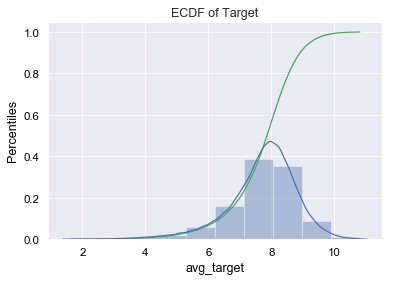

In [79]:
# distribution of target
ecdf_ = ECDF(train_df["avg_target"]) #x, y = ecdf(train_df["sum_target"])
plt.plot(ecdf_.x, ecdf_.y, "g-", label="ECDF")
plt.title("ECDF of Target")
plt.xlabel("Target Values")
plt.ylabel("Percentiles")

_ = sns.distplot(train_df["avg_target"], bins=10)
# should we transform the target?

In [80]:
# package preprocessed data into CSV
train_df.to_csv("./train_preproc_v1.csv", index=False)
test_df.to_csv("./test_preproc_v1.csv", index=False)
gc.collect()

32

In [ ]:
# Time for AutoML!

In [81]:
# combine predictions
prediction_df = pd.read_csv("./predictions.csv", usecols=[object_id, "predict"])
prediction_df.rename(columns={"predict": target}, inplace=True)
prediction_df = prediction_df[[object_id, target]]
print(prediction_df.shape)
prediction_df.head()

(146765, 2)


,reservation_id,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d4787cb4596e3086b4f,7.960
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb1946e644b405d6233c,7.488
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e38f40dcb4ce0c4f552,7.587
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd26796a33cc98b01c6095c4,7.859
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1b2d117cd6602737ec1,7.779


In [82]:
prediction_df.to_csv("./submission.csv", index=False)

In [ ]:
# Public LB RMSE: 97.43
# Private LB RMSE: 98.76